<a href="https://colab.research.google.com/github/rogerpanel/CV/blob/main/Transformer_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install torch

In [3]:
pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 73.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.9 MB/s eta 0:00:00


In [4]:
#import Libraries
import torch
import librosa
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import ViTModel, ViTConfig
from sklearn.manifold import TSNE


In [6]:

# Load audio file
audio_file = '/content/1. male1a.wav'
audio, sr = librosa.load(audio_file)

# Set parameters for audio frames
frame_length = 2048
hop_length = 512

# Convert audio into audio frames
frames = librosa.util.frame(audio, frame_length=frame_length, hop_length=hop_length)

# Load image file
image_file = '/content/1. cucumber_fruit.jpg'
image = cv2.imread(image_file)

# Set parameters for image patching
patch_size = 64

# Calculate the maximum number of patches that can be extracted from the image
max_patches = (image.shape[0] // patch_size) * (image.shape[1] // patch_size)

# Ensure the number of audio frames matches the number of image patches
if len(frames) > max_patches:
    frames = frames[:max_patches]
elif len(frames) < max_patches:
    # Pad audio frames with zeros if needed
    frames = np.pad(frames, ((0, max_patches - len(frames)), (0, 0)), mode='constant')

In [7]:

# Partition the image into patches
patches = []
for i in range(0, image.shape[0], patch_size):
    for j in range(0, image.shape[1], patch_size):
        patch = image[i:i+patch_size, j:j+patch_size]
        patches.append(patch)

# Helper functions
def process_frame(frame):
    # Apply transformations or analysis on audio frame
    processed_frame = frame
    # Do something with processed frame
    return processed_frame

def process_patch(patch):
    # Apply preprocessing or feature extraction on image patch
    processed_patch = patch
    # Do something with processed patch
    return processed_patch

def embed_audio(patch, audio_embedding):
    # Embed audio information within image patch
    # Example: Store audio embedding value in the blue channel of the patch
    patch[:, :, 0] = audio_embedding
    return patch


In [8]:


# Create lists to store embedded audio information and patch coordinates
embeddings = []
coordinates = []

# Embed audio information within specific patches of the image
for i in range(len(frames)):
    frame = frames[i]
    patch = patches[i]

    # Apply preprocessing or feature extraction on each patch and frame
    processed_patch = process_patch(patch)
    processed_frame = process_frame(frame)

    # Embed audio information within specific patch
    audio_embedding = np.mean(processed_frame)  # Example: using mean of audio frame as embedding value
    processed_patch_with_audio = embed_audio(processed_patch, audio_embedding)

    # Replace the original patch with the processed patch containing audio information
    patches[i] = processed_patch_with_audio

    # Store audio embedding and patch coordinates
    embeddings.append(audio_embedding)
    coordinates.append((i % (image.shape[1] // patch_size), i // (image.shape[1] // patch_size)))

# Reconstruct the image from the processed patches
reconstructed_image = np.zeros_like(image)
patch_index = 0
for i in range(0, reconstructed_image.shape[0], patch_size):
    for j in range(0, reconstructed_image.shape[1], patch_size):
        patch = patches[patch_index]
        reconstructed_image[i:i+patch_size, j:j+patch_size] = patch
        patch_index += 1


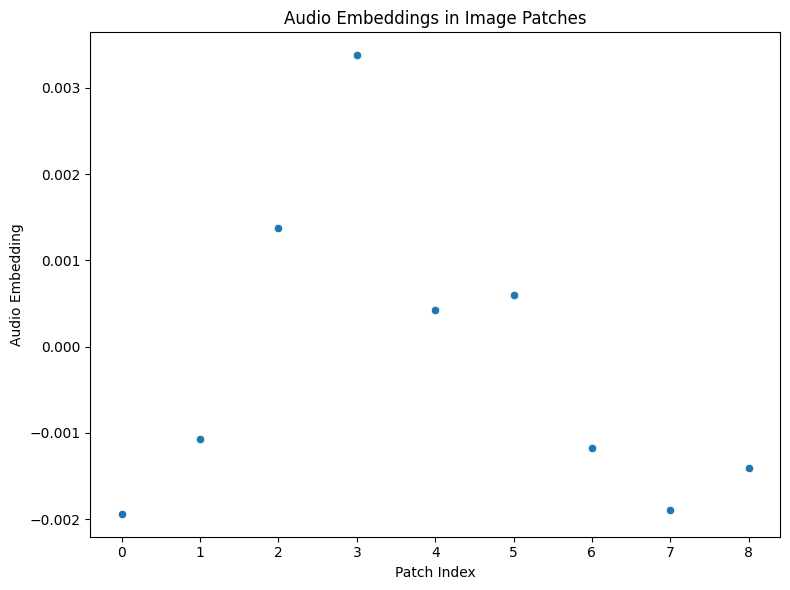

In [9]:

# Create a scatter plot to visualize the audio embeddings in the image patches
plt.figure(figsize=(8, 6))
sns.scatterplot(x=np.arange(len(embeddings)), y=embeddings)
plt.xlabel('Patch Index')
plt.ylabel('Audio Embedding')
plt.title('Audio Embeddings in Image Patches')
plt.tight_layout()
plt.savefig('audio_embeddings_scatterplot.png')
plt.show()

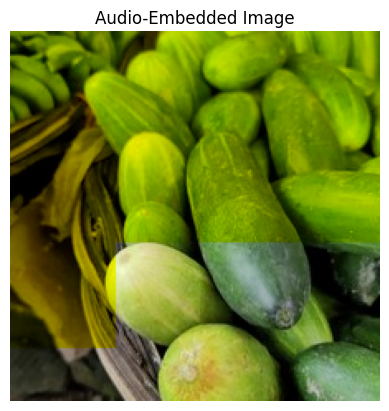

Audio-Image embedding result saved as /content/output/image.jpg


In [10]:

# Display the final audio-embedded image
plt.imshow(cv2.cvtColor(reconstructed_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Audio-Embedded Image')
plt.show()

# Save the reconstructed image with embedded audio information
output_image_file = '/content/output/image.jpg'
cv2.imwrite(output_image_file, reconstructed_image)

print("Audio-Image embedding result saved as", output_image_file)


In [11]:
import numpy as np
import os

# Specify the output image file path with .npy extension
output_image_file_npy = '/content/output/image_npy.npy'

# Create the output directory if it doesn't exist
output_directory = os.path.dirname(output_image_file_npy)
os.makedirs(output_directory, exist_ok=True)

# Save the reconstructed image as a NumPy array
np.save(output_image_file_npy, reconstructed_image)

print("Audio-Image embedding result saved as", output_image_file_npy)


Audio-Image embedding result saved as /content/output/image_npy.npy


In [12]:
from google.colab import files
files.download(output_image_file_npy)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:


# Load ViT model
config = ViTConfig(hidden_size=768, num_hidden_layers=12, num_attention_heads=12, intermediate_size=3072, num_channels=9)
model = ViTModel(config)

audio_images = output_image_file_npy

# Convert audio frames to "image" format
audio_images = np.stack(frames, axis=0)

# Normalize audio images to values between 0 and 1
audio_images = audio_images / np.max(audio_images)

# Resize audio images to match the expected input size of ViT model
resized_audio_images = []
for audio_image in audio_images:
    resized_image = cv2.resize(audio_image, (224, 224))
    resized_audio_images.append(resized_image)
resized_audio_images = np.stack(resized_audio_images)

# Reshape audio images to match the expected input shape of ViT model
audio_images = resized_audio_images.reshape(1, resized_audio_images.shape[0], resized_audio_images.shape[1], resized_audio_images.shape[2])

# Convert audio images to torch tensor
audio_images_tensor = torch.from_numpy(audio_images)

# Pass audio images through ViT model
output = model(audio_images_tensor)

# Perform further processing or analysis on the output
# ...


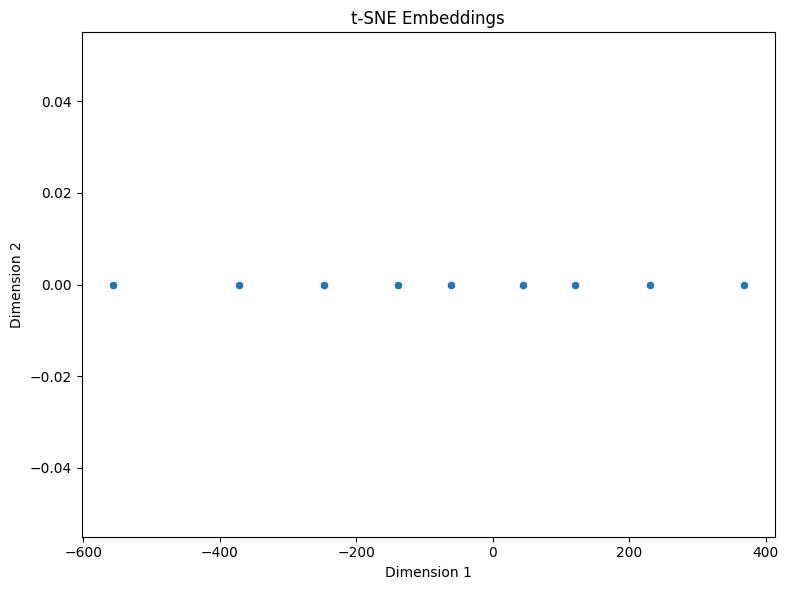

In [14]:
import numpy as np

# Convert embeddings list to numpy array
embeddings_array = np.array(embeddings)

# Reshape embeddings array to 2 dimensions
embeddings_2d = embeddings_array.reshape(embeddings_array.shape[0], -1)

# Visualize the output embeddings using t-SNE
n_components = min(2, min(embeddings_2d.shape))
tsne = TSNE(n_components=n_components, perplexity=2, random_state=42)  # Adjust perplexity as needed
embeddings_tsne = tsne.fit_transform(embeddings_2d)

# Plot the t-SNE embeddings
plt.figure(figsize=(8, 6))
if n_components == 1:
    sns.scatterplot(x=embeddings_tsne[:, 0], y=np.zeros_like(embeddings_tsne[:, 0]))
else:
    sns.scatterplot(x=embeddings_tsne[:, 0], y=embeddings_tsne[:, 1])
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE Embeddings')
plt.tight_layout()
plt.savefig('tsne_embeddings.png')
plt.show()


<ipython-input-15-9ae3fa3afb01>:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('viridis', len(patch_indices))


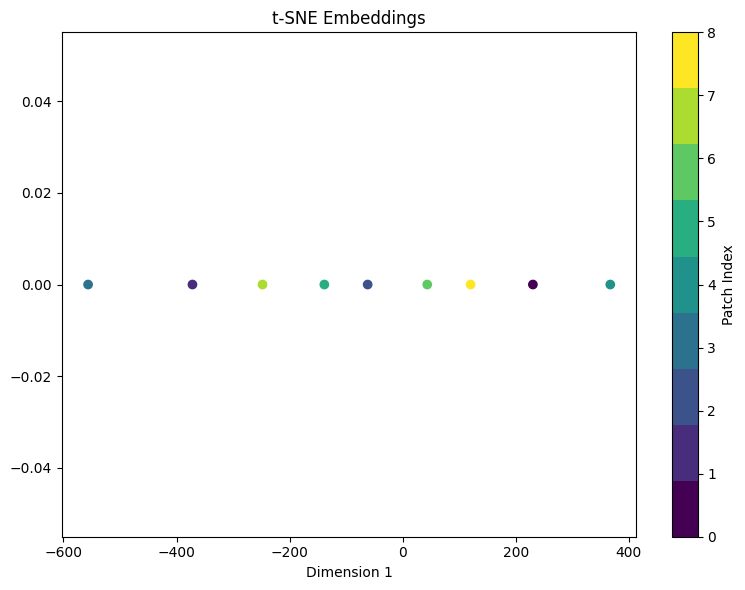

In [15]:
import numpy as np

# Convert embeddings list to numpy array
embeddings_array = np.array(embeddings)

# Reshape embeddings array to 2 dimensions
embeddings_2d = embeddings_array.reshape(embeddings_array.shape[0], -1)

# Visualize the output embeddings using t-SNE
tsne = TSNE(n_components=1, perplexity=2, random_state=42)  # Adjust perplexity as needed
embeddings_tsne = tsne.fit_transform(embeddings_2d)

# Create a color map based on patch index
patch_indices = np.arange(len(embeddings))
color_map = plt.cm.get_cmap('viridis', len(patch_indices))

# Plot the t-SNE embeddings with color based on patch index
plt.figure(figsize=(8, 6))
scatter = plt.scatter(embeddings_tsne, np.zeros_like(embeddings_tsne), c=patch_indices, cmap=color_map)
plt.xlabel('Dimension 1')
plt.title('t-SNE Embeddings')
plt.colorbar(scatter, label='Patch Index')
plt.tight_layout()
plt.savefig('tsne_embeddings.png')
plt.show()


In [16]:
from transformers import ViTModel

In [17]:
import torch
from transformers import ViTModel

# Load ViT model
config = ViTConfig(hidden_size=768, num_hidden_layers=12, num_attention_heads=12, intermediate_size=3072, num_channels=9)
model = ViTModel(config)

audio_images == output_image_file

# Convert audio frames to "image" format
audio_images = np.stack(frames, axis=0)

# Normalize audio images to values between 0 and 1
audio_images = audio_images / np.max(audio_images)

# Resize audio images to match the expected input size of ViT model
resized_audio_images = []
for audio_image in audio_images:
    resized_image = cv2.resize(audio_image, (224, 224))
    resized_audio_images.append(resized_image)
resized_audio_images = np.stack(resized_audio_images)

# Reshape audio images to match the expected input shape of ViT model
audio_images = resized_audio_images.reshape(1, resized_audio_images.shape[0], resized_audio_images.shape[1], resized_audio_images.shape[2])
# Convert audio images to torch tensor
audio_images_tensor = torch.from_numpy(audio_images)

# Pass audio images through ViT model
output = model(audio_images_tensor)

# Visualize attention heatmaps
#attention_weights = []
#for layer_num, attention_map in enumerate(model.get_attention_map()):
#    attention_map = torch.mean(attention_map, dim=1)  # Average attention across heads
#    attention_weights.append(attention_map.squeeze().detach().numpy())
#
#for layer_num, layer_attention in enumerate(attention_weights):
#    plt.figure(figsize=(8, 6))
#    sns.heatmap(layer_attention, cmap='Blues', xticklabels=False, yticklabels=False)
#    plt.title(f'Attention Heatmap - Layer {layer_num+1}')
#    plt.savefig(f'attention_heatmap_layer{layer_num+1}.png')
#    plt.show()


<ipython-input-17-eeaf8815a9ae>:8: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  audio_images == output_image_file


In [21]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import ViTModel, ViTConfig
# Load ViT model
config = ViTConfig(hidden_size=768, num_hidden_layers=12, num_attention_heads=12, intermediate_size=3072, num_channels=9)
model = ViTModel(config)

audio_images == output_image_file

# Convert audio frames to "image" format
audio_images = np.stack(frames, axis=0)

# Normalize audio images to values between 0 and 1
audio_images = audio_images / np.max(audio_images)

# Resize audio images to match the expected input size of ViT model
resized_audio_images = []
for audio_image in audio_images:
    resized_image = cv2.resize(audio_image, (224, 224))
    resized_audio_images.append(resized_image)
resized_audio_images = np.stack(resized_audio_images)

# Reshape audio images to match the expected input shape of ViT model
audio_images = resized_audio_images.reshape(1, resized_audio_images.shape[0], resized_audio_images.shape[1], resized_audio_images.shape[2])
# Convert audio images to torch tensor
audio_images_tensor = torch.from_numpy(audio_images)

# Pass audio images through ViT model
output = model(audio_images_tensor)

# Get attention weights from the self-attention matrices
attention_weights = []
for layer_num, layer in enumerate(model.encoder.layer):
    attention_map = layer.attention.output.attention_probs.squeeze(0)
    attention_map = torch.mean(attention_map, dim=1)  # Average attention across heads
    attention_weights.append(attention_map.squeeze().detach().numpy())

for layer_num, layer_attention in enumerate(attention_weights):
    plt.figure(figsize=(8, 6))
    sns.heatmap(layer_attention, cmap='Blues', xticklabels=False, yticklabels=False)
    plt.title(f'Attention Heatmap - Layer {layer_num+1}')
    plt.savefig(f'attention_heatmap_layer{layer_num+1}.png')
    plt.show()


<ipython-input-21-ab3ff08646f1>:10: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  audio_images == output_image_file


AttributeError: ignored

In [ ]:
# To assess the performance of the steganographic technique
#and compare it with existing methods, you can consider the following code
#snippets as starting point:

In [18]:
import numpy as np

# Load the stego audio image
stego_images = np.load('/content/image_npy_1.npy')

# Calculate the image size from the stego audio image shape
image_size = stego_images.shape[1]  # Assumes the shape is (num_patches, image_size, image_size, num_channels)

# Calculate the embedding capacity
embedding_capacity = len(stego_images) * (patch_size / image_size)
print("Embedding Capacity:", embedding_capacity)


Embedding Capacity: 64.0


In [19]:
import librosa

# Load the original audio file
original_audio, sr = librosa.load('/content/1. male1a.wav')

# Load the extracted audio
extracted_audio, sr = librosa.load('/content/output_audio.wav')

# Calculate the distortion level
distortion_level = np.mean(np.abs(original_audio - extracted_audio))
print("Distortion Level:", distortion_level)


Distortion Level: 0.35585076


In [20]:
import numpy as np
from skimage.io import imread
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from skimage.transform import resize

# Load the original cover image
cover_image = imread('/content/1. cucumber_fruit.jpg')

# Load the stego image in .npy format
stego_image = np.load('/content/image_npy_1.npy')  # Replace 'stego_image.npy' with the actual stego image file name

# Resize the images to have the same dimensions
stego_image = resize(stego_image, cover_image.shape, preserve_range=True, anti_aliasing=True)

# Calculate the PSNR and SSIM between cover image and stego image
psnr = peak_signal_noise_ratio(cover_image, stego_image)
ssim = structural_similarity(cover_image, stego_image, multichannel=True)

print("PSNR:", psnr)
print("SSIM:", ssim)


PSNR: 12.622577009585271
SSIM: 0.6741858326384252


<ipython-input-20-d9148dc3bb0d>:16: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(cover_image, stego_image)
<ipython-input-20-d9148dc3bb0d>:17: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim = structural_similarity(cover_image, stego_image, multichannel=True)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)
